In [ ]:
import pandas 
import numpy as np 
import gc
import random
from collections import OrderedDict
from sklearn.preprocessing import * 
from keras.models import *
from keras.layers import *

In [ ]:

%pip install patool

from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/duolingo/processed.rar /content/

import patoolib
patoolib.extract_archive("processed.rar", outdir="/content")
!gzip -dv /content/processed.npy.gz


dataset = np.asarray(np.load('processed.npy')).astype(np.float)  
np.random.shuffle(dataset)   

dataset = dataset[0:1000000]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.6 MB/s 
Mounted at /content/drive
patool: Extracting processed.rar ...
patool: running /usr/bin/unrar x -- /content/processed.rar
patool:     with cwd='/content'
patool: ... processed.rar extracted to `/content'.
gzip: /content/processed.npy.gz: No such file or directory


<ipython-input-2-977e3b30efe6>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset = np.asarray(np.load('processed.npy')).astype(np.float)


In [ ]:
# constants
MINIMUM_ROWS_PER_SEQUENCE = len(dataset[0])
MAX_AUGMENTATION_DELTA_0 = 1000
TRAIN_TEST_SPLIT = 0.9

# curve:
# p = 2^(−∆/h)
# we use all the data except the last element
# we predict in one neuron h, then we take in input delta of the last element
# and using the formula in another neuron we calculate p

In [ ]:
# RNN input calc

 
output = np.array(dataset[:,dataset.shape[1]-1, 0])
output = np.expand_dims(output, axis=1) 
rnn_input = np.array(dataset[:,0:(MINIMUM_ROWS_PER_SEQUENCE-1), :])
delta_input = np.array(dataset[:,dataset.shape[1]-1:dataset.shape[1],1]) 

rnn_input_test = rnn_input[int(len(rnn_input)*TRAIN_TEST_SPLIT):]
rnn_input = rnn_input[:int(len(rnn_input)*TRAIN_TEST_SPLIT)] 
output_test = output[int(len(output)*TRAIN_TEST_SPLIT):]
output = output[:int(len(output)*TRAIN_TEST_SPLIT)]
delta_input_test = delta_input[int(len(delta_input)*TRAIN_TEST_SPLIT):]
delta_input = delta_input[:int(len(delta_input)*TRAIN_TEST_SPLIT)]
 

# momentaneamente usiamo solo train
# quando useremo test, dobbiamo fare finta di averlo solo alla fine
# ossia non lo normalizziamo all'inizio ma solo dopo l'allenamento
# dropout?

In [ ]:
# Here we do some data augmentation
# for each sample, we add another sample according to the last output

adding_input_rnn = []
adding_input_delta = []
adding_output = []
for i in range(int(len(rnn_input))):
  
    did = []
    if output[i] == 0:
        for i in range(8):
            last_rnn = np.array(rnn_input[i])
            last_delta = np.array(delta_input[i])
            last_delta[0] = random.randint(last_delta[0]+1, last_delta[0]+1+MAX_AUGMENTATION_DELTA_0)
            if last_delta[0] not in did:
                adding_output.append([0])
                adding_input_rnn.append(last_rnn)
                adding_input_delta.append(last_delta)
                did.append(last_delta[0])
    elif delta_input[i][0] > 0: 
        for i in range(8): 
            last_rnn = np.array(rnn_input[i])
            last_delta = np.array(delta_input[i])
            last_delta[0] = random.randint(0, last_delta[0]-1)
            if last_delta[0] not in did:
                adding_output.append([1])
                adding_input_rnn.append(last_rnn)
                adding_input_delta.append(last_delta)
                did.append(last_delta[0])
 

print(len(rnn_input))
rnn_input = np.concatenate( (rnn_input,np.array(adding_input_rnn)) )
delta_input = np.concatenate( (delta_input,np.array(adding_input_delta)) )
output = np.concatenate( (output,np.array(adding_output)) )
print(len(rnn_input))

 

900000
6703881


In [ ]:
# creating a weighted loss

'''
m = dict()
for i in rnn_input:
    if int(i[-1][1]) not in m:
        m[int(i[-1][1]) ] = 0
    m[int(i[-1][1])] += 1
'''

total_1 = sum([(1 if i[0] == 1 else 0) for i in output])
total_0 = sum([(1 if i[0] == 0 else 0) for i in output])
total_others = len(output)-total_1-total_0

# weights_calc = np.array([ 1.0/m[int(i[-1][1])] if m[int(i[-1][1])] > 1000 else 1.0/(m[1])  for i in rnn_input])
weights_calc = np.array([(1 if i[0] != 1 else 1) for i in output]) 

In [ ]:
# we do have 6 elements, each one with: p_recall, delta, history_seen, history_correct, session_seen, session_correct
# we keep 5 of those for the LSTM RNN
# we use another network with the 6th element and 5 features (all except p_recall)
# we connect the networks and try to predict the last p_recall

tf.keras.backend.clear_session() 
from keras import regularizers


class HalfLifeLayer(tf.keras.layers.Layer):
    
  def __init__(self):
    super(HalfLifeLayer, self).__init__()

  def build(self, input_shape): 
    return

  def call(self, inputs):
      # outputs shape 
      # curve:
      # p = 2^(−∆/h)
      #tf.keras.backend.print_tensor(inputs, message='y = ')
      return tf.pow(2.0, -tf.divide(inputs[:,0:1], inputs[:,1:2]+1e-6))

rnn_layer_input = Input(shape=rnn_input[0].shape)
rnn_layer_0 = Masking(mask_value=-1.0)(rnn_layer_input)
rnn_layer_1 = GRU(20,dropout=0.1, recurrent_dropout=0.13, kernel_regularizer=regularizers.L2(0.001), recurrent_regularizer=regularizers.L2(0.001))(rnn_layer_0)
dense_layer_0 = Dropout(0.13)(Dense(20, activation='relu',  kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(0.01)) (rnn_layer_1))
dense_layer_1 = Dense(1, activation='relu', name="cases") (dense_layer_0) 

delta_layer_input = Input(shape=delta_input[0].shape)
merge = concatenate([delta_layer_input, dense_layer_1]) # in order: delta, half life
output_layer = HalfLifeLayer()(merge)

#dense_layer_000 = Dropout(0.13)(Dense(20, activation='relu',  kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(0.01)) (rnn_layer_1))
#output_layer = Dense(1, activation='sigmoid', name="cases") (dense_layer_000)  

model = Model([rnn_layer_input, delta_layer_input], [output_layer])
metrics=["AUC", "MAE"]
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), loss="binary_crossentropy", metrics=metrics)


# beta regression 
#print(rnn_input[:6])
model.fit([rnn_input, delta_input], output,sample_weight=weights_calc, epochs=10000, batch_size=10000, validation_data=([rnn_input_test, delta_input_test], output_test))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10000
90/90 [==============================] - 9s 54ms/step - loss: 1.8306 - auc: 0.4713 - MAE: 0.4912 - val_loss: 0.9882 - val_auc: 0.4847 - val_MAE: 0.4366
Epoch 2/10000
90/90 [==============================] - 4s 46ms/step - loss: 0.9208 - auc: 0.5118 - MAE: 0.4291 - val_loss: 0.8188 - val_auc: 0.5467 - val_MAE: 0.4073
Epoch 3/10000
90/90 [==============================] - 4s 46ms/step - loss: 0.8107 - auc: 0.5443 - MAE: 0.4092 - val_loss: 0.7494 - val_auc: 0.5603 - val_MAE: 0.3964
Epoch 4/10000
90/90 [==============================] - 5s 50ms/step - loss: 0.7570 - auc: 0.5568 - MAE: 0.3983 - val_loss: 0.7103 - val_auc: 0.5674 - val_MAE: 0.3880
Epoch 5/10000
90/90 [==============================] - 5s 50ms/step - loss: 0.7249 - auc: 0.5639 - MAE: 0.3906 - val_loss: 0.6861 - val_auc: 0.5798 - val_MAE: 0.3762
Epoch 6/10000
90/90 [==============================] - 4s 46ms/step - loss: 0.7007 - auc: 0.5706 - MAE: 0.3846 - val_loss: 0.6634 - val_auc: 0.5903 - val_MAE: 0.3797
Epoc

KeyboardInterrupt: ignored

In [ ]:
print(rnn_input[7])
print(output[7])

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+

In [ ]:
model.evaluate([rnn_input_test[:,0,:], rnn_input_test[:,1,:],rnn_input_test[:,2,:],rnn_input_test[:,3,:],rnn_input_test[:,4,:],rnn_input_test[:,5,:], dense_input_test], output_test)

In [ ]:
rnn_input_test[3][-1][1]

3.249386574074074

In [ ]:
maxx = 0
for i in rnn_input:
    if i[-1][1] > maxx:
        maxx = i[-1][1]
print(maxx)

11.016168981481481


[[[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [ 0.  0.]
  [ 1.  1.]
  [ 1.  3.]
  [ 1.  9.]
  [ 1. 15.]
  [ 1. 24.]]]
[[38.]]
43659
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


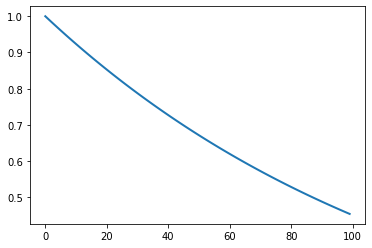

In [ ]:

  ind = np.random.randint(0, len(rnn_input_test))
  example_rnn = np.array(np.expand_dims(rnn_input_test[ind], 0))
  example_dense = np.array(np.expand_dims(delta_input_test[ind], 0))
  print(example_rnn) 
  print(example_dense) 
  print(ind)
 
  if True:
    x = []
    y = []
    for i in range(100):
      j = (i)
      x.append(j)
      
      '''
      for i in range(len(example_rnn[0])):
          example_rnn[0][i][0] = 1
          example_rnn[0][i][1] = 1000
      '''
      example_dense[0][0] = j 
      
      #print(example_dense)
      #print(model.predict([example_rnn],verbose = 0))
      y.append(model.predict([example_rnn, example_dense],verbose = 0)[0][0])
!pip install matplotlib

import matplotlib.pyplot as plt 

# make data
x = np.array(x)
y = np.array(y)

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)
 

plt.show()

 